In [1]:
code_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/code"
import os, sys
if code_dir not in sys.path:
    sys.path.append(code_dir)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# load scene coordinate data

In [3]:
data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_full/"

In [4]:
data_size = 370
images = np.zeros((data_size, 256, 512, 3), dtype=np.int16)
scene_coords = np.zeros((data_size, 256, 512, 3), dtype=np.float32)
pixel_bearings = np.zeros((data_size, 256, 512, 3), dtype=np.float32)

for data in tqdm(range(1,data_size + 1)):
    coord_npz = f"{data:04}_rendered.png_config.npz"
    npz_data = np.load(data_dir + coord_npz)
    
    images[int(data)-1,:,:,:] = npz_data['image_colors']
    scene_coords[int(data)-1,:,:,:] = npz_data['points_3d_world'] 
    pixel_bearings[int(data)-1,:,:,:] = npz_data['points_3d_sphere']

100%|██████████| 370/370 [00:04<00:00, 77.60it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


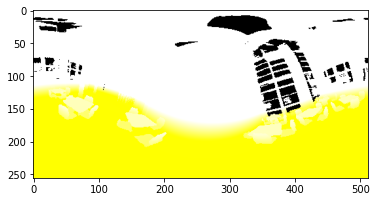

In [54]:
plt.imshow(scene_coords[199])

# Get masks

In [55]:
scene_coords_summed = np.sum(scene_coords, axis=-1)
mask = np.where(scene_coords_summed == 0, 0, 1).astype(bool)

In [57]:
mask.shape

(370, 256, 512)

In [60]:
mask_flattened = np.reshape(mask, (-1))
mask_flattened.shape

(48496640,)

# Create grid

In [56]:
scene_coords_flattened = np.reshape(scene_coords, (-1,3))
scene_coords_flattened.shape

(48496640, 3)

In [61]:
scene_coords_flattened_masked = scene_coords_flattened[mask_flattened]
scene_coords_flattened_masked.shape

(47708029, 3)

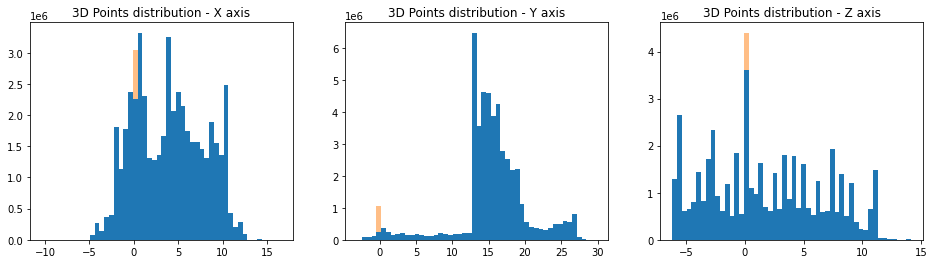

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

ax1.hist(scene_coords_flattened[:,0], bins=50, alpha=0.5, color='tab:orange')
ax1.hist(scene_coords_flattened_masked[:,0], bins=50, color='tab:blue')
ax1.set_title("3D Points distribution - X axis")

ax2.hist(scene_coords_flattened[:,1], bins=50, alpha=0.5, color='tab:orange')
ax2.hist(scene_coords_flattened_masked[:,1], bins=50, color='tab:blue')
ax2.set_title("3D Points distribution - Y axis")

ax3.hist(scene_coords_flattened[:,2], bins=50, alpha=0.5, color='tab:orange')
ax3.hist(scene_coords_flattened_masked[:,2], bins=50, color='tab:blue')
ax3.set_title("3D Points distribution - Z axis")

# orange bar visualises how many points were removed due to msking ([0,0,0] points)
plt.show()

### first split each dim in half -> make 2by2by2 grid

In [72]:
xyz_regions = np.quantile(scene_coords_flattened_masked, 0.5, axis=0)
xyz_regions

array([ 3.88867188, 15.390625  ,  1.18261719])

In [102]:
def bin_to_dec(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

def get_region_gt(ind=199):
    region_gt = np.zeros((256,512,3))
    
    # region label in binary format
    region_gt[scene_coords[ind,:,:,0] < xyz_regions[0],0] = 1
    region_gt[scene_coords[ind,:,:,1] < xyz_regions[1],1] = 1
    region_gt[scene_coords[ind,:,:,2] < xyz_regions[2],2] = 1
    region_gt = np.reshape(region_gt, (-1,3))
    
    # convert to decimal (categorical label)
    region_gt_categorical = np.reshape(np.zeros((256,512)), (-1))
    for ind, row in enumerate(region_gt):
        region_gt_categorical[ind] = bin_to_dec(row)
        
    # reshape to image size
    return np.reshape(region_gt_categorical, (256,512))

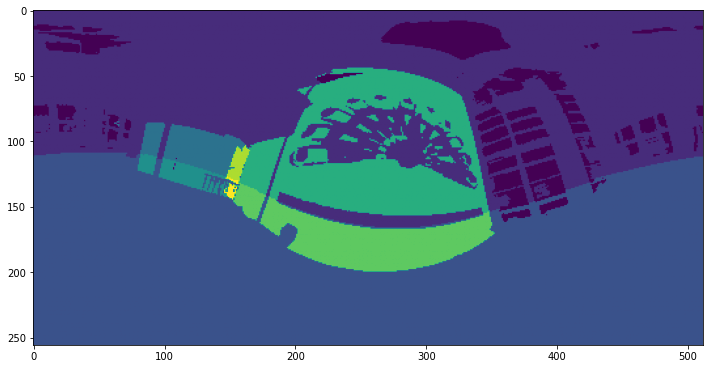

In [90]:
ind = 199
region_gt = get_region_gt(ind)
region_gt = region_gt * mask[ind]

# darkest regions are masked out as they are not beeing classified
plt.figure(figsize=(12,8))
plt.imshow(region_gt)

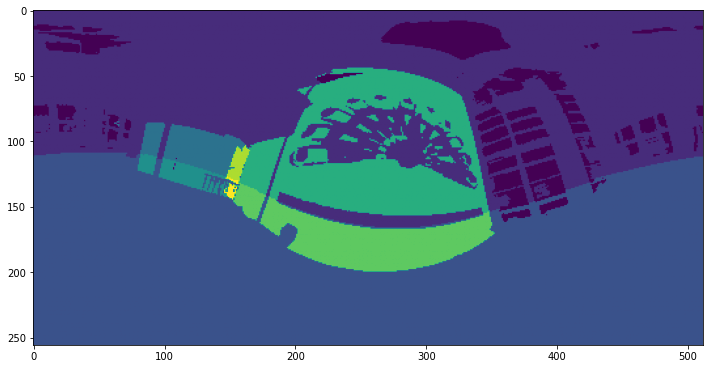

In [99]:
ind = 199
region_gt = get_region_gt(ind)
region_gt = region_gt * mask[ind]

# darkest regions are masked out as they are not beeing classified
plt.figure(figsize=(12,8))
plt.imshow(region_gt)

In [100]:
np.unique(region_gt)

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

# Save gt-reg-labels to .npz file

In [103]:
for ind in tqdm(range(370)):
    region_gt = get_region_gt(ind)
    file_name = f"{ind+1:04}_simple_region_class.npy"
    np.save(data_dir + file_name, region_gt)

100%|██████████| 370/370 [05:10<00:00,  1.19it/s]


In [101]:
for ind in tqdm(range(370)):
    mask_file = mask[ind]
    file_name = f"{ind+1:04}_mask.npy"
    np.save(data_dir + file_name, mask_file)

100%|██████████| 370/370 [00:44<00:00,  8.32it/s]
